In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
torch.cuda.set_device(1)

### Preparing the data

In [4]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/deep/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/home/deep/.fastai/data/imdb_sample/data_save.pkl')]

In [5]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [6]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [7]:
data_lm = TextDataBunch.from_csv(path,'texts.csv')

In [8]:
data_lm.save()

In [9]:
data=load_data(path)


#### Tokenization and numericalization are made in order to turn the text into to numbers. Later, these numbers are involved in mathematical functions.

## Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

1. we need to take care of punctuation
2. some words are contractions of two different words, like isn't or don't
3. we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [10]:
data = TextClasDataBunch.from_csv(path,'texts.csv')
data.show_batch()

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded xxunk experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative


## Numericalization 

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token UNK.

In [11]:
data.vocab.itos[:11]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

In [12]:
data.train_ds[0][0]

Text xxbos xxmaj if you liked watching xxmaj mel xxmaj xxunk in xxmaj million xxmaj dollar xxmaj hotel then you might enjoy watching xxmaj burt xxmaj reynolds in yet another film so bad it could never be distributed . i can only xxunk to the xxup dvd version so maybe the xxup vhs version is better quality wise but the movies night and dark scenes have been so poorly done that xxunk seems red . i first thought my xxup dvd players was messed up . xxmaj it was n't . xxmaj if you insist on watching it i recommend you adjust the color on your xxup tv until it is black and white . xxmaj if you do n't you will never be able to get through the film . xxmaj if you do it will simply remind you of a poor film students attempt to xxunk the style of xxmaj pulp xxmaj fiction .

In [13]:
data.train_ds[0][0].data[:10]

array([   2,    5,   59,   33,  369,  168,    5, 3778,    5,    0])

### With the data block API

In [14]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language Model

In [15]:
bs=48

In [16]:
path=untar_data(URLs.IMDB)

In [17]:
(path/'train').ls()

[PosixPath('/home/deep/.fastai/data/imdb/train/neg'),
 PosixPath('/home/deep/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/deep/.fastai/data/imdb/train/pos'),
 PosixPath('/home/deep/.fastai/data/imdb/train/labeledBow.feat')]

In [18]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [19]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [20]:
data_lm.show_batch()

idx,text
0,"original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in"
1,""" banned film "" . i was very disappointed . \n \n xxmaj cannibal xxmaj ferox does not work because it is so campy and fake . xxmaj most of the time the camera does not show you the "" shocking "" stabs , chops , slicing - you just see the aftermath . ( xxmaj they do show a breast hooking in detail ) . xxmaj the special"
2,if improbable ... and then we go right into the movie which takes improbable to new levels . xxmaj of course this is a lame remake of the 1979 thriller starring xxmaj carol xxmaj kane as the babysitter xxmaj jill xxmaj johnson xxrep 4 . now xxmaj jill is some chick that ran her cell phone minutes up so high her evil parents are punishing her by making her work
3,"even though the caller occasionally drops into his normal voice ) , the audience always knows : no suspense . xxmaj each call rattles her more and more . \n \n xxmaj the ending was unexpected for me , so maybe gets points for not going with the obvious , but i 'm not sure i cared for it . xxbos a long time ago , way back in"
4,"it 's good for an xxmaj adamson film ? xxmaj well , the story is n't all bad and he was able to build tension very well . xxmaj many false alarms early on made my heart race a bit . xxmaj also , the car crash , while irrelevant , came off pretty well and was practically big - budget for xxmaj adamson . \n \n xxmaj overall"


In [21]:
learn = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


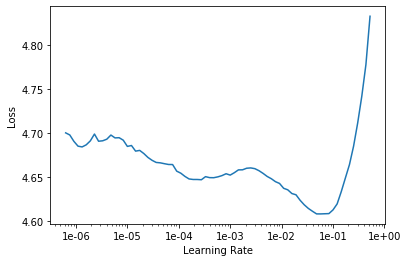

In [22]:
learn.lr_find()
learn.recorder.plot(skip_end = 15)

In [37]:
learn.fit_one_cycle(1,0.8e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.145401,4.017704,0.296283,17:37


In [40]:
learn.save('fit_head')

In [41]:
learn.load('fit_head');

In [42]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


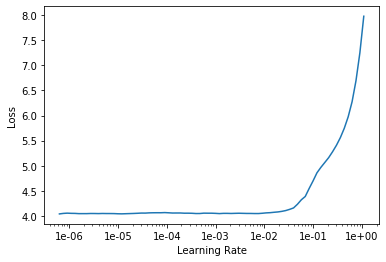

In [44]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10,1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.866807,3.817917,0.317446,19:52
1,3.827729,3.780960,0.324246,19:56
2,3.782219,3.748095,0.328304,19:58
3,3.747576,3.711583,0.333031,19:58
4,3.656816,3.681233,0.336439,19:58


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [24]:
path = untar_data(URLs.IMDB)

In [25]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [26]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [27]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",pos
"xxbos xxmaj by 1987 xxmaj hong xxmaj kong had given the world such films as xxmaj sammo xxmaj hung 's ` xxmaj encounters of the xxmaj spooky xxmaj kind ' xxmaj chow xxmaj yun xxmaj fat in xxmaj john xxmaj woo 's iconic ` a xxmaj better xxmaj tomorrow ' , ` xxmaj zu xxmaj warriors ' and the classic ` xxmaj mr xxmaj vampire ' . xxmaj jackie xxmaj",pos
"xxbos 8 xxmaj simple xxmaj rules for xxmaj dating xxmaj my xxmaj teenage xxmaj daughter had an auspicious start . xxmaj the supremely - talented xxmaj tom xxmaj shadyac was involved in the project . xxmaj this meant that the comedy would be nothing less of spectacular , and that 's exactly what happened : the show remains one of the freshest , funniest , wittiest shows made in a",pos
"xxbos xxmaj the vigilante has long held a fascination for audiences , inasmuch as it evokes a sense of swift , sure justice ; good triumphs over evil and the bad guy gets his deserts . xxmaj it is , in fact , one of the things that has made the character of xxmaj dirty xxmaj harry xxmaj callahan ( as played by xxmaj clint xxmaj eastwood ) so popular",pos


In [37]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i was bored , around 10 pm , so i watched this movie . xxmaj and i could not stop laughing . xxmaj everything was so ridiculous . xxmaj the way the kids were acting like they were older than 11 just cracked me up . xxmaj one of the kids had a ring , that supposedly killed people after 3 or so years . xxmaj it gave me the impression that he wanted to be a gangster . 
 
  xxmaj it 's pretty hard to take little kids seriously , especially when it has to do with eating worms . xxmaj they act like everything is such a big deal , like if xxmaj billy ( the main character ) does n't eat the worms then the world will end . 
 
  xxmaj this is a good movie for little kids ( excluding the fact that a 5 year old says ' penis ' ) , but not for teens or adults who do n't want to waste their time .,xxbos xxmaj bill ( xxmaj buddy xxmaj rogers ) is sent to xxmaj new xxmaj york by his uncle ( xxmaj richard xxmaj tucker )

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.550611,0.507198,0.750440,02:13


In [ ]:
learn.save('first')
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [35]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [31]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [36]:
learn.predict("I really loved that movie, it was awesome!")

(Category neg, tensor(0), tensor([0.7460, 0.2540]))

In [32]:
learn.validate()

[0.59969085, tensor(0.7101)]